In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [4]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 64
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))


488396 4883 1526 1221


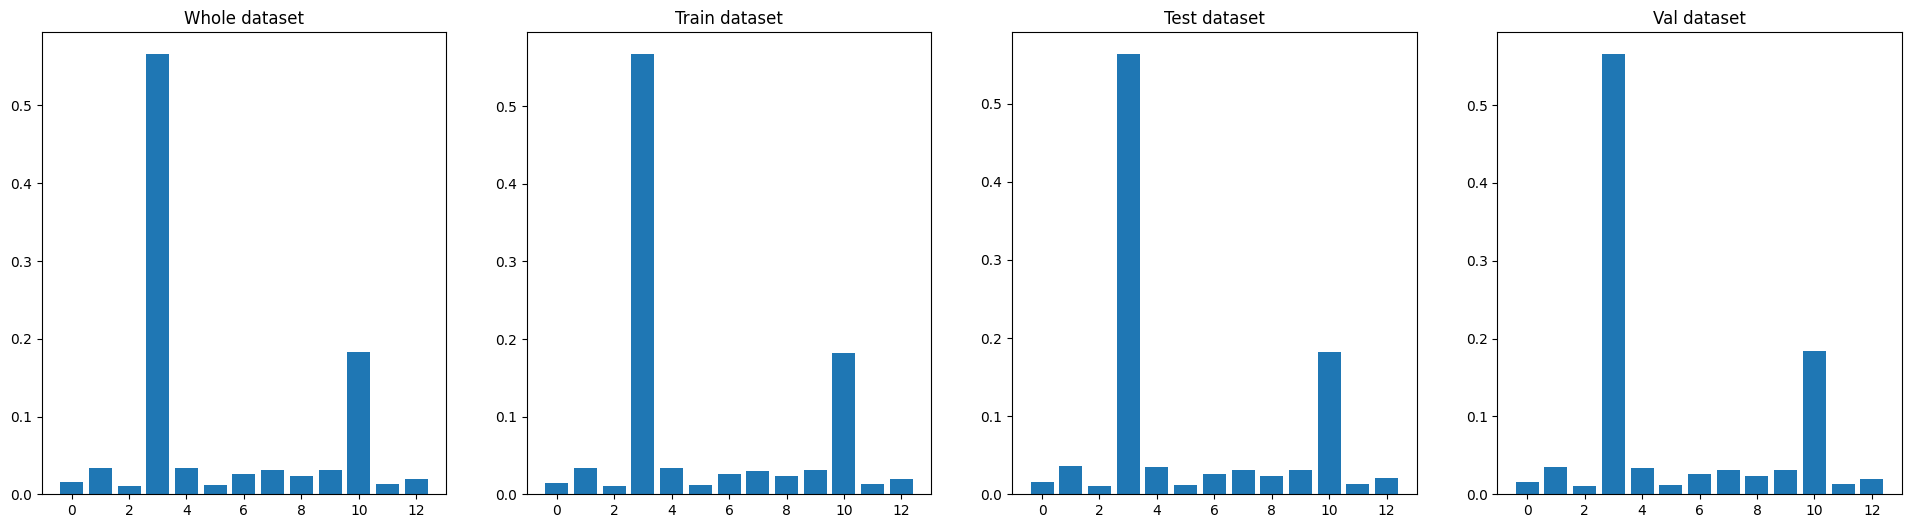

In [5]:
# check if the split is stratified
# make the 4 plots side by side
plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
plt.title("Whole dataset")
targets = np.array(dataset.dataset.targets)
unique, counts = np.unique(targets, return_counts=True)
plt.bar(unique, counts/len(dataset))
plt.subplot(1,4,2)
plt.title("Train dataset")
train_targets = np.array(train_subset.dataset.dataset.targets)[train_subset.indices]
train_unique, train_counts =  np.unique(train_targets, return_counts=True)
plt.bar(train_unique, train_counts/len(train_subset))
plt.subplot(1,4,3)
plt.title("Test dataset")
test_targets = np.array(test_subset.dataset.dataset.targets)[test_subset.indices]
test_unique, test_counts =  np.unique(test_targets, return_counts=True)
plt.bar(test_unique, test_counts/len(test_subset))
plt.subplot(1,4,4)
plt.title("Val dataset")
val_targets = np.array(val_subset.dataset.dataset.targets)[val_subset.indices]
val_unique, val_counts =  np.unique(val_targets, return_counts=True)
plt.bar(val_unique, val_counts/len(val_subset))
plt.show()

# combine in the same plot using plotly express
df = pd.DataFrame({
    "Dataset": ["Whole"]*len(unique) + ["Train"]*len(train_unique) + ["Test"]*len(test_unique) + ["Val"]*len(val_unique),
    "Class": np.concatenate([unique, train_unique, test_unique, val_unique]),
    "Percentage": np.concatenate([counts/len(dataset), train_counts/len(train_subset), test_counts/len(test_subset), val_counts/len(val_subset)])
})

fig = px.bar(df, x="Class", y="Percentage", color="Dataset", barmode="group")
fig.show()



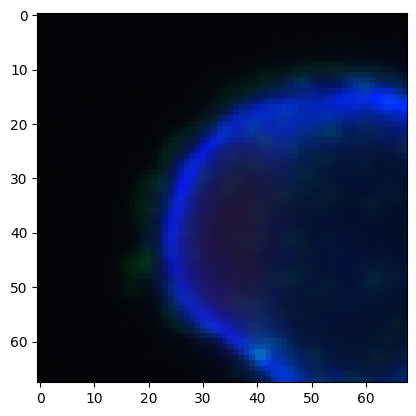

In [6]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [7]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


# VAE

In [8]:
from models import VAE_LAFARGE, VAE_CELL_CNN, VAE_CELL_CNN_2
from loss_functions import loss_function

model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
print(model)

if cuda:
    model = model.cuda()

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=lr)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(dim=1, unflattened_size=(256, 9, 9))
    (5): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyRe

In [9]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])


## Training

In [10]:
torch.autograd.set_detect_anomaly(True)

val = True

num_epochs = 50
train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)


        optimizer.step()



        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        mse_batch_loss = []
        kld_batch_loss = []
        for x, y in val_loader:
            if cuda:
                x = x.cuda()

            output_val = model(x)
            x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
            loss_fn = loss_function(x, x_hat, mu, sigma)
            mse_loss = loss_fn["MSE"]
            kld_loss = loss_fn["KLD"]
            loss = loss_fn["loss"]

            batch_loss.append(loss.item())
            mse_batch_loss.append(mse_loss.item())
            kld_batch_loss.append(kld_loss.item())

        val_loss.append(np.mean(batch_loss))
        val_mse_loss.append(np.mean(mse_batch_loss))
        val_kld_loss.append(np.mean(kld_batch_loss))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best_model.pth")


    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")
    # plot_latent(output)



Epoch 1/50, loss: 8236.186233348639, mse_loss: 6409.753271074391, kld_loss: 1826.4329612283173, val_loss: 5912.097098385672, val_mse_loss: 3969.9587130409886, val_kld_loss: 1942.1383856446112
Epoch 2/50, loss: 6271.358354639182, mse_loss: 4249.0540788733715, kld_loss: 2022.3042750408383, val_loss: 5352.438218625231, val_mse_loss: 3295.9614621723995, val_kld_loss: 2056.4767577525145
Epoch 3/50, loss: 6066.880705680902, mse_loss: 4000.673847474257, kld_loss: 2066.206856456712, val_loss: 5159.426265932126, val_mse_loss: 3057.0032322139255, val_kld_loss: 2102.4230356177377
Epoch 4/50, loss: 5970.259492135502, mse_loss: 3883.0995929256314, kld_loss: 2087.1599011097974, val_loss: 5001.827574333922, val_mse_loss: 2937.1798070709206, val_kld_loss: 2064.647771961859
Epoch 5/50, loss: 5910.259120149786, mse_loss: 3812.1728120140187, kld_loss: 2098.086307160805, val_loss: 5022.6086899666, val_mse_loss: 2954.8044199650644, val_kld_loss: 2067.804269501657
Epoch 6/50, loss: 5870.253240675558, mse_lo

In [11]:
loss_function(x, x_hat, mu, sigma)

# F.mse_loss(x, x_hat)

model.encode(x)

(tensor([[-0.0215,  0.0270,  0.0086,  ..., -0.0104, -0.2271, -0.0065],
         [ 0.0480, -0.0241,  0.0625,  ...,  0.0187, -1.1690,  0.0254],
         [ 0.0311,  0.0667, -0.0726,  ..., -0.1412, -0.1922,  0.0890],
         ...,
         [ 0.1099, -0.0128, -0.0189,  ..., -0.0214,  2.6843, -0.0647],
         [-0.0900,  0.0606, -0.1239,  ...,  0.0147,  0.3028,  0.0604],
         [-0.0293,  0.0167, -0.0257,  ...,  0.0272, -2.0246,  0.0702]],
        device='cuda:0', grad_fn=<SplitBackward0>),
 tensor([[ 1.2008e-02, -3.7872e-03, -8.6839e-03,  ..., -8.2128e-03,
          -1.9991e+00,  8.1437e-03],
         [ 1.8884e-02, -2.2457e-03, -1.0565e-02,  ..., -1.8161e-02,
          -2.0958e+00,  8.0549e-03],
         [-2.3154e-02,  5.2096e-02, -1.3598e-02,  ...,  3.0807e-03,
          -8.4810e-01, -3.5272e-02],
         ...,
         [-1.0251e-02,  4.2741e-03, -3.0800e-02,  ...,  6.0302e-03,
          -2.7062e+00, -3.3196e-03],
         [-3.0698e-02, -2.3832e-02, -3.9271e-03,  ..., -5.9595e-03,
     

## Plots

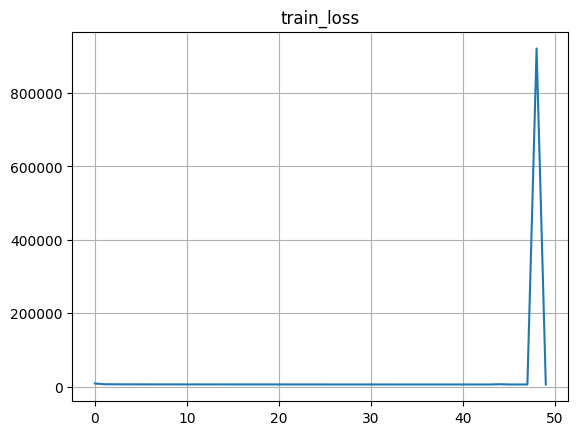

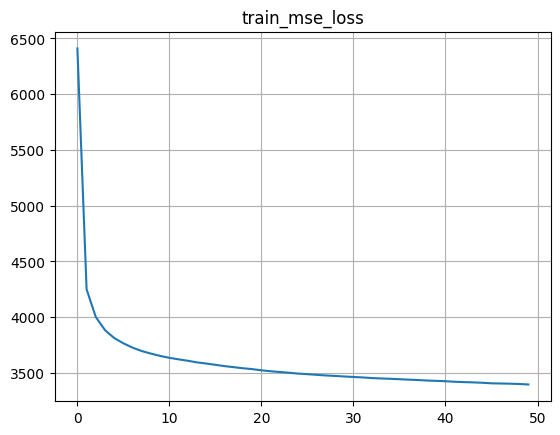

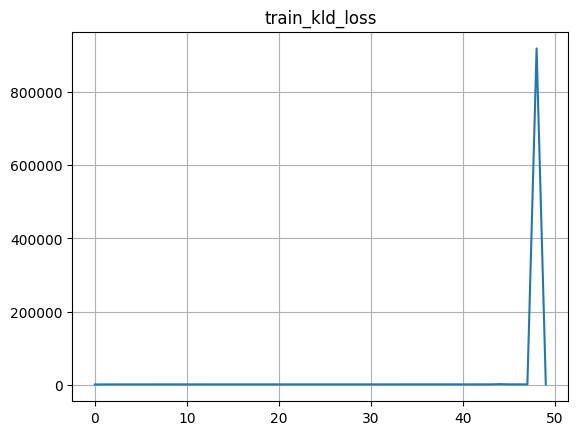

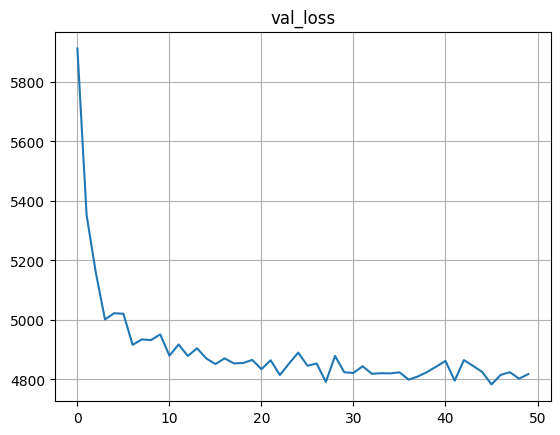

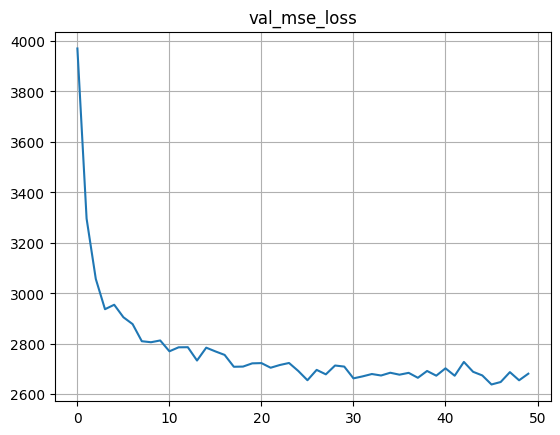

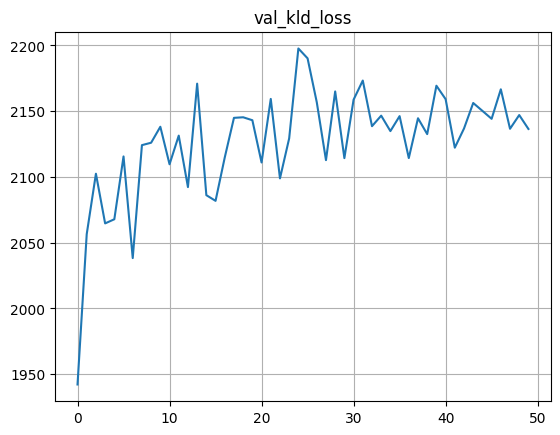

In [12]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss
loss_data["val_loss"] = val_loss
loss_data["val_mse_loss"] = val_mse_loss
loss_data["val_kld_loss"] = val_kld_loss
loss_plots(loss_data, invidual_plots=True)

df = pd.DataFrame(loss_data)
try:
    old_df = pd.read_csv(f"{model.__class__.__name__}_loss_data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(f"{model.__class__.__name__}_loss_data.csv", index=False)


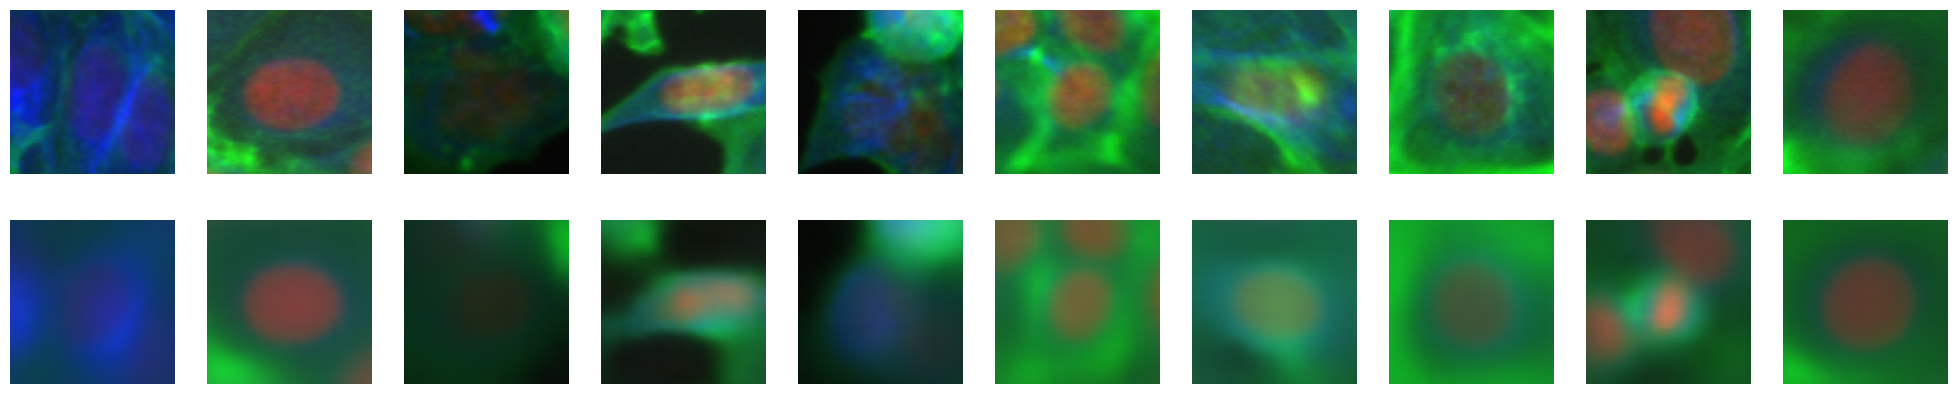

In [13]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


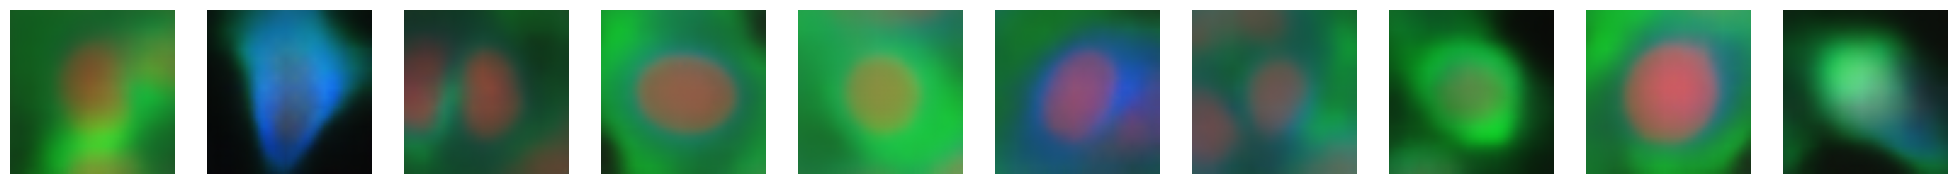

In [14]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [15]:
from inference import Inference

inference = Inference(model, test_loader)

In [16]:
samples = inference.samples

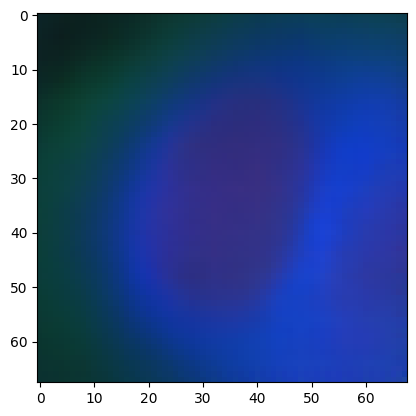

In [17]:
show_img(samples['1'][3])